In [1]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from datetime import datetime 
from datetime import timedelta

import scipy.interpolate as interp

scrip.so not found. Remapping function will not be available


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Assessment of the OSSE simulations

An assesment of the OSSE simulations will be done here. We will try to perform it in a analogue way to the one done for the OSE, where real observations were used for assimilation and assesment.

- SLA: The value of the NR at the position of the regular satellite tracks will be extracted and compared to the simulations.
    
- SST: The NR surface temperature field will be considered and subsampled, reducing the resolution to 10 km by picking one of every four observations both in vertical and horizontal.
    
- ARGO: Temperature and salinity profiles at position of the buoys during the experiment will be extracted from NR and simulations and compared
    
- TS profiles will algo be assesed in areas of the domain distant from assimialt4ed observations. This way, the capabilities of the model will also be assesed.

- HFR: The data samples taken apart for validation will be used for this purpose

### <font color='red'> In this case we will directly extract de WMOP output and NR fields and compare them </font> 

#### Set Bounding Box to consider velocities from

In [3]:
limits = [0.1, 1.3,  38.3, 39.2]  # Future coverage area
#limits = [0.72, 1.2, 38.6, 38.85]  # actual coverage

#limits = [0.2, 1.2,  38.6, 39.0]

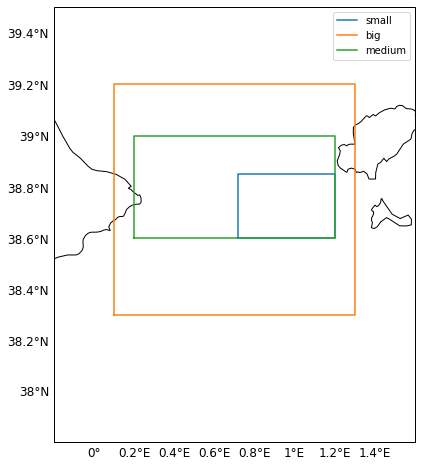

In [4]:
l1 = [-0.2, 1.6, 37.8, 39.5]

limits1 = [0.72, 1.2, 38.6, 38.85]
limits2 = [0.1, 1.3,  38.3, 39.2]
limits3 = [0.2, 1.2,  38.6, 39.0]

plt.figure(figsize=(8,8))

ax,gl = tools.make_map(continents=False, limits=l1)

plt.plot([limits1[0], limits1[0], limits1[1], limits1[1], limits1[0]], [limits1[2],limits1[3],limits1[3],limits1[2],limits1[2] ], transform=gl.crs)
plt.plot([limits2[0], limits2[0], limits2[1], limits2[1], limits2[0]], [limits2[2],limits2[3],limits2[3],limits2[2],limits2[2] ], transform=gl.crs)
plt.plot([limits3[0], limits3[0], limits3[1], limits3[1], limits3[0]], [limits3[2],limits3[3],limits3[3],limits3[2],limits3[2] ], transform=gl.crs)

plt.legend(['small', 'big','medium'])
plt.show()

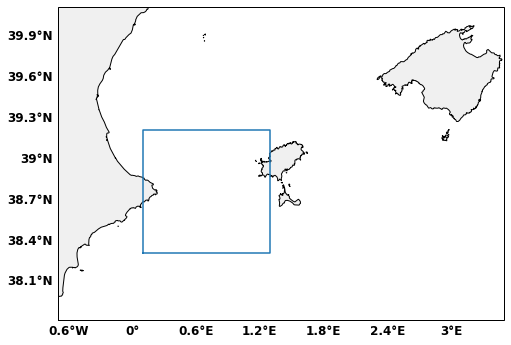

In [96]:
l1 = [-0.7, 3.5, 37.8, 40.1]

limits1 = [0.72, 2, 38.6, 38.85]
limits2 = [0.1, 1.3,  38.3, 39.2]

fig = plt.figure(figsize=(8,6))

ax,gl = tools.make_map(continents=True, limits=l1)

#plt.plot([limits1[0], limits1[0], limits1[1], limits1[1], limits1[0]], [limits1[2],limits1[3],limits1[3],limits1[2],limits1[2] ], transform=gl.crs)
plt.plot([limits2[0], limits2[0], limits2[1], limits2[1], limits2[0]], [limits2[2],limits2[3],limits2[3],limits2[2],limits2[2] ], transform=gl.crs)
#plt.plot([limits3[0], limits3[0], limits3[1], limits3[1], limits3[0]], [limits3[2],limits3[3],limits3[3],limits3[2],limits3[2] ], transform=gl.crs)

#plt.legend(['small', 'big','medium'])
plt.show()

fig.savefig('/home/jhernandez/Escritorio/validation_domain.png', dpi=250)

## HFR

In [5]:
# Get values of fields from WMOP simulations
exp_names = ['NOASSIM', 'generic_nudging', 'all_future_nudging', 'all_actual_nudging', 'generic_nonudging', 'all_future_nonudging', 'all_actual_nonudging']

u = {}
v = {}

for exp in exp_names:

    if exp in ['NOASSIM']:
        path_wmop = '/home/modelling/data/workdir_2/HFR_DA/HFR_{0}_Oct2014'.format(exp)
    else:
        path_wmop = '/DATA/jhernandez/ROMS/Outputs/HFR_{0}_Oct2014_OSSE_v2/'.format(exp)
       

    file_wmop = '{0}/roms_WMOP_ASSIM_2014*_avg.nc'.format(path_wmop)
    ds_wmop = xr.open_mfdataset(file_wmop)

    du = ds_wmop['u'].where((ds_wmop.lon_u>limits[0]) & (ds_wmop.lon_u<limits[1]) & (ds_wmop.lat_u>limits[2]) & (ds_wmop.lat_u<limits[3]), drop=True)
    dv = ds_wmop['v'].where((ds_wmop.lon_v>limits[0]) & (ds_wmop.lon_v<limits[1]) & (ds_wmop.lat_v>limits[2]) & (ds_wmop.lat_v<limits[3]), drop=True)

    u[exp] = du[:,-1,:,:].values
    v[exp] = dv[:,-1,:,:].values
    
    print('Fields within the Radar domain extracted for {0}'.format(exp))

Fields within the Radar domain extracted for NOASSIM
Fields within the Radar domain extracted for generic_nudging
Fields within the Radar domain extracted for all_future_nudging
Fields within the Radar domain extracted for all_actual_nudging
Fields within the Radar domain extracted for generic_nonudging
Fields within the Radar domain extracted for all_future_nonudging
Fields within the Radar domain extracted for all_actual_nonudging


## Load Observations

Load observations from the NR. For every day load the dataset, subset the area of interest and perform daily mean

In [7]:
# Load Observations (NR)

# Define initial and end date
date = datetime(2014,9,21)
date_end = datetime(2014,10,20)

# number of days of simulation
ndays = (date_end - date).days

# Loop over days
for i in range(ndays):

    strdate = date.strftime('%Y%m%d')

    path_wmop = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch/'
    file_wmop = '{0}roms_WMOP_FORECAST_{1}_his.nc'.format(path_wmop, strdate)
    ds_wmop = xr.open_dataset(file_wmop)

    du = ds_wmop['u'].where((ds_wmop.lon_u>limits[0]) & (ds_wmop.lon_u<limits[1]) & (ds_wmop.lat_u>limits[2]) & (ds_wmop.lat_u<limits[3]), drop=True)
    dv = ds_wmop['v'].where((ds_wmop.lon_v>limits[0]) & (ds_wmop.lon_v<limits[1]) & (ds_wmop.lat_v>limits[2]) & (ds_wmop.lat_v<limits[3]), drop=True)

    if i==0:
        u_obs = np.empty((ndays, du.shape[2], du.shape[3]))
        v_obs = np.empty((ndays, dv.shape[2], dv.shape[3]))
        
    u_obs[i,:,:] = du[:,-1,:,:].mean(axis=0).values
    v_obs[i,:,:] = dv[:,-1,:,:].mean(axis=0).values
    
    date = date + timedelta(days=1)

print(' Observations extracted from de NR for the HF Radar domain in the Ibiza Channel')

 Observations extracted from de NR for the HF Radar domain in the Ibiza Channel


In [ ]:
du.shape

### Calcualte RMSD

For each of the different experiments the RMSD is calculated for every day of simulation, interpolating the SLA field to the postion of the observations. The positions will be considered the same all along the experiment

In [26]:
import scipy.interpolate as interp
import skill_metrics as sm

# Define initial and end date
date = datetime(2014,9,21)
date_end = datetime(2014,10,19)

# Experiment names from which to extract equivalents to observations and to calculate RMSD
exp_names = ['NOASSIM', 'generic_nudging', 'all_future_nudging', 'all_actual_nudging', 'generic_nonudging', 'all_future_nonudging', 'all_actual_nonudging']

# number of days of simulation
ndays = (date_end - date).days


# Initialize empty dictionary and arrays
rmsd_u = {}
rmsd_v = {}
u_obs_total = {}  # array containing all observations (concatenate each day obs)
u_wmop_total = {}  # array containing all wmop obs
v_obs_total = {}  # array containing all observations (concatenate each day obs)
v_wmop_total = {}  # array containing all wmop obs
for exp in exp_names:
    rmsd_u[exp] = np.empty(ndays)
    rmsd_v[exp] = np.empty(ndays)
    u_obs_total[exp] = np.array([])
    u_wmop_total[exp] = np.array([])
    v_obs_total[exp] = np.array([])
    v_wmop_total[exp] = np.array([])    
    
    # Loop over days
    for i in range(ndays):

        strdate = date.strftime('%Y%m%d')  

        u_wmop = u[exp][i,:,:].reshape(-1)
        u_wmop = u_wmop[~np.isnan(u_wmop)]        
        v_wmop = v[exp][i,:,:].reshape(-1)
        v_wmop = v_wmop[~np.isnan(v_wmop)]

        u_obs1 = u_obs[i,:,:].reshape(-1)
        u_obs1 = u_obs1[~np.isnan(u_obs1)]        
        v_obs1 = v_obs[i,:,:].reshape(-1)
        v_obs1 = v_obs1[~np.isnan(v_obs1)]

        # Compute RMSD
        rmsd_u[exp][i] = sm.rmsd(u_wmop, u_obs1)
        rmsd_v[exp][i] = sm.rmsd(v_wmop, v_obs1)
        
        #rmsd_u[exp][i] = np.sqrt( np.nanmean( np.square(u_obs1-u_wmop)))
        #rmsd_v[exp][i] = np.sqrt( np.nanmean( np.square(v_obs1-v_wmop)))

        u_obs_total[exp] = np.concatenate((u_obs_total[exp], u_obs1))
        u_wmop_total[exp] = np.concatenate((u_wmop_total[exp], u_wmop))
        v_obs_total[exp] = np.concatenate((v_obs_total[exp], v_obs1))
        v_wmop_total[exp] = np.concatenate((v_wmop_total[exp], v_wmop))

       # print(rmsd[exp][i])
    
    #print('')
        date = date + timedelta(days=1)
    

    #print(strdate)
print('done')

done


In [25]:
(28+18+15)/8


7.625

In [128]:
from skill_metrics import centered_rms_dev as crmsd
from skill_metrics import bias
print(crmsd(u_wmop, u_obs1))
print(bias(u_wmop, u_obs1))
print(sm.rmsd(u_wmop, u_obs1))


0.12936699265545465
0.024622202173814035
0.1316892993900168


In [9]:
t0 = datetime(2014,9,21)
t = [t0 + timedelta(days=i) for i in range(31)]
xt = range(0,31,3)
tt = [time.strftime('%d/%m/%Y') for time in t]

In [10]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

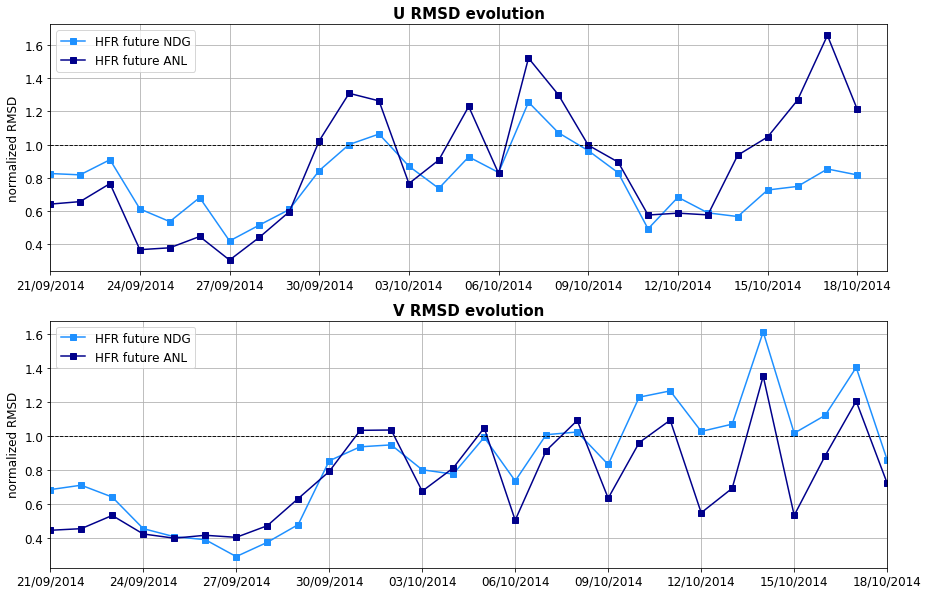

In [20]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['NOASSIM', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['m', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [3,4]
#subset = [1,3,5]
#subset = [2,4,6]
#subset = [1,2,3,4,5,6]
exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]


fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for i, exp in enumerate(exp_names):
    
    ax1.plot(rmsd_u[exp] / rmsd_u['NOASSIM'], marker='s', linestyle='-', color=colors[i])
    ax2.plot(rmsd_v[exp] / rmsd_v['NOASSIM'], marker='s', linestyle='-', color=colors[i])
    #ax1.plot(rmsd_u[exp], marker='s', linestyle='-', color=colors[i])
    #ax2.plot(rmsd_v[exp], marker='s', linestyle='-', color=colors[i])
ax1.legend(labels)
ax1.grid(True)
ax1.set_xticks(ticks=list(xt))
ax1.set_xticklabels(labels=tt[0:-1:3])
ax1.set_ylabel('normalized RMSD')
ax1.set_xlim((0,28))

ax2.legend(labels)
ax2.grid(True)
ax2.set_xticks(ticks=list(xt))
ax2.set_xticklabels(labels=tt[0:-1:3])
plt.xlim((0,27))
ax2.set_ylabel('normalized RMSD')

ax1.set_title('U RMSD evolution', fontsize=15, fontweight='bold')
ax2.set_title('V RMSD evolution', fontsize=15, fontweight='bold')

ax1.plot(range(31), [1]*31, 'k--', linewidth=0.9)  # Mark value=1
ax2.plot(range(31), [1]*31, 'k--', linewidth=0.9)  # Mark value=1

plt.show()

In [142]:
fig.savefig('/home/jhernandez/Escritorio/OSSE_v2/rmsd_evolution_Velocities_big_OSSE_ndg.png', dpi=250)

In [21]:
for exp in exp_names[:]:
    #print(np.mean(rmsd_u[exp], axis=0))
    print(exp)
    print(np.mean(rmsd_v[exp], axis=0)/ np.mean(rmsd_v['NOASSIM'], axis=0))
    print('')

all_future_nudging
0.7921372034251919

all_future_nonudging
0.7024732798384216



In [ ]:
for exp in exp_names:
    
    print(exp)
    print(np.mean(rmsd_u[exp], axis=0)/ np.mean(rmsd_u['NOASSIM'], axis=0))
    print('')

In [ ]:
for exp in exp_names:
    
    print(exp)
    print(np.mean(rmsd_v[exp], axis=0)/ np.mean(rmsd_v['NOASSIM'], axis=0))
    print('')

## Taylor Diagram

In [76]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['CR', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [0,1,3,5]
subset = [0,2,4,6]
exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]


sdev = []; crmsd = []; ccoef = []; taylor_stats = {}

# Calculate taylor diagram stats for the different experiments selcted
for e in exp_names:
    taylor_stats[e] = sm.taylor_statistics(u_wmop_total[e], u_obs_total[e])
    sdev.append(taylor_stats[e]['sdev'][1])
    crmsd.append(taylor_stats[e]['crmsd'][1])
    ccoef.append(taylor_stats[e]['ccoef'][1])

# Add reference value and convert to array
sdev = np.array([taylor_stats['NOASSIM']['sdev'][0]] + sdev)
crmsd = np.array([taylor_stats['NOASSIM']['crmsd'][0]] + crmsd)
ccoef = np.array([taylor_stats['NOASSIM']['ccoef'][0]] + ccoef)

In [77]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

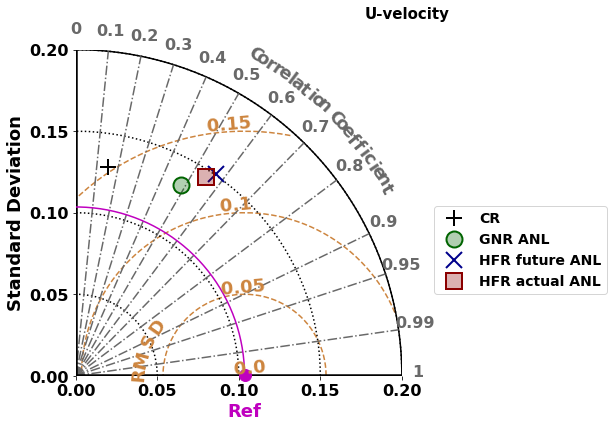

In [78]:
label = ['HFR'] + labels
#colors = [ 'black',  'darkgreen', 'darkblue', 'darkred']
#colors = [ 'black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

fig_taylor_u = plt.figure(num=1, figsize=(17,6))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel=label,  markerLabelColor = 'r', markerDisplayed = 'marker',
                      markerLegend = 'on', markercolor = colors,
                      styleOBS = '-', colOBS = 'm', markerobs = 'o',
                      markerSize = 16, tickRMS = [0.0, 0.05, 0.1, 0.15], 
                      colRMS = 'peru', colCOR = 'dimgrey',
                      tickRMSangle = 95, showlabelsRMS = 'on', axismax=0.2,
                      titleRMS = 'on', titleOBS = 'Ref', checkstats = 'on', alpha=0.3)#, overlay=True)

plt.suptitle('U-velocity', fontsize=15, fontweight='bold')
plt.show()

In [75]:
fig_taylor_u.savefig('/home/jhernandez/Escritorio/OSSE_v2/taylor_diagram_U_big_OSSE_anl.png', dpi=250)

## V-velocity

In [61]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['CR', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [0,1,3,5]
subset = [0,2,4,6]
#exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]


sdev = []; crmsd = []; ccoef = []; taylor_stats = {}

# Calculate taylor diagram stats for the different experiments selcted
for e in exp_names:
    taylor_stats[e] = sm.taylor_statistics(v_wmop_total[e], v_obs_total[e])
    sdev.append(taylor_stats[e]['sdev'][1])
    crmsd.append(taylor_stats[e]['crmsd'][1])
    ccoef.append(taylor_stats[e]['ccoef'][1])

# Add reference value and convert to array
sdev = np.array([taylor_stats['NOASSIM']['sdev'][0]] + sdev)
crmsd = np.array([taylor_stats['NOASSIM']['crmsd'][0]] + crmsd)
ccoef = np.array([taylor_stats['NOASSIM']['ccoef'][0]] + ccoef)

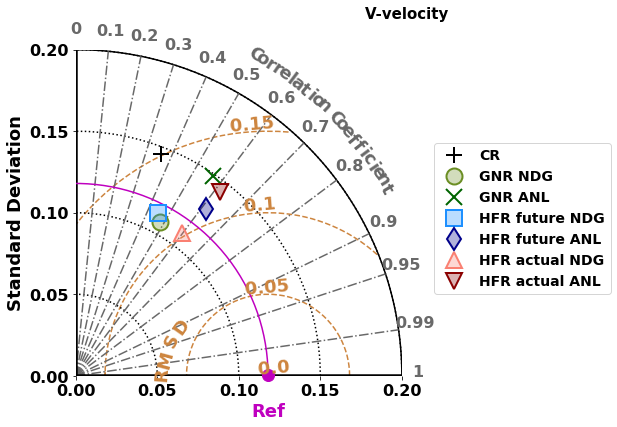

In [62]:
label = ['HFR'] + labels
#colors = [ 'black',  'darkgreen', 'darkblue', 'darkred']
#colors = [ 'black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

fig_taylor_v = plt.figure(num=1, figsize=(17,6))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel=label,  markerLabelColor = 'r', markerDisplayed = 'marker',
                      markerLegend = 'on', markercolor = colors,
                      styleOBS = '-', colOBS = 'm', markerobs = 'o',
                      markerSize = 16, tickRMS = [0.0, 0.05, 0.1, 0.15], 
                      colRMS = 'peru', colCOR = 'dimgrey',
                      tickRMSangle = 95, showlabelsRMS = 'on', axismax=0.2,
                      titleRMS = 'on', titleOBS = 'Ref', checkstats = 'on', alpha=0.3)#, overlay=True)

plt.suptitle('V-velocity', fontsize=15, fontweight='bold')
plt.show()

In [63]:
fig_taylor_v.savefig('/home/jhernandez/Escritorio/OSSE_v2/taylor_diagram_V_big_OSSE_all.png', dpi=250)

## BIAS

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
exp_names = ['NOASSIM','all_future_nudging', 'all_actual_nudging', 'generic_nudging']
legend_names = ['NOASSIM', 'HFR future NDG', 'HFR actual NDG', 'GNR NDG']

for exp in exp_names:
    
    bias_u = np.mean((u[exp][0:-1,:,:] - u_obs[0::,:,:]), axis=0)
    bias_v = np.mean((v[exp][0:-1,:,:] - v_obs[0::,:,:]), axis=0)
    
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    ax, gl = tools.make_map(continents=False, limits=limits, subplot_dim=121)
    plt.pcolormesh(du.lon_u, du.lat_u, bias_u, cmap='RdBu_r', transform=gl.crs, vmin=-0.3, vmax=0.3)
    plt.colorbar()
    plt.title('BIAS U.  {0}'.format(exp))
     
    plt.subplot(122)    
    ax, gl = tools.make_map(continents=False, limits=limits, subplot_dim=122)
    plt.pcolormesh(dv.lon_v, dv.lat_v, bias_v, cmap='RdBu_r', transform=gl.crs, vmin=-0.3, vmax=0.3)
    plt.colorbar()
    plt.title('BIAS V.  {0}'.format(exp))
    
    plt.show()
    

In [ ]:
exp_names = ['NOASSIM','all_future_nudging', 'all_actual_nudging', 'generic_nudging']
legend_names = ['NOASSIM', 'HFR future NDG', 'HFR actual NDG', 'GNR NDG']

for exp in exp_names:
    
    rmsd_u = np.sqrt( np.mean(np.square( (u[exp][0:-1,:,:] - u_obs[0::,:,:]) ), axis=0) )
    rmsd_v = np.sqrt( np.mean(np.square( (v[exp][0:-1,:,:] - v_obs[0::,:,:]) ), axis=0) )
    
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    ax, gl = tools.make_map(continents=False, limits=limits, subplot_dim=121)
    plt.pcolormesh(du.lon_u, du.lat_u, rmsd_u, cmap='Blues', transform=gl.crs, vmin=0, vmax=0.2)
    plt.colorbar()
    plt.title('RMSD U.  {0}'.format(exp))
     
    plt.subplot(122)    
    ax, gl = tools.make_map(continents=False, limits=limits, subplot_dim=122)
    plt.pcolormesh(dv.lon_v, dv.lat_v, rmsd_v, cmap='Blues', transform=gl.crs, vmin=0, vmax=0.2)
    plt.colorbar()
    plt.title('RMSD V.  {0}'.format(exp))
    
    plt.show()

## Load Shapefiles of the coverage areas

We are going to load the shapefiles created as a proxy of the present and future HF Radar coverage areas. We have used this coverage areas to create the velocities observations from the NR

In [49]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

coverage_name = ['actual', 'future']
lonc = {}
latc = {}

for cov in coverage_name:
    # Path  to Nature Run
    nr_path = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch/'

    # Path to shapefile
    shape_path = '/home/jhernandez/Escritorio/hfr_coverage_geodata/'
    shape_file = glob(shape_path + '/*' + cov + '*shp')
    # Load Shapefile
    shape = shapefile.Reader(shape_file[0])

    feature = shape.shapeRecords()[0]
    first = feature.shape.__geo_interface__ 
    coverage = Polygon(feature.shape.points)
    
    lonc[cov] = [c[0] for c in first['coordinates'][0]]
    latc[cov] = [c[1] for c in first['coordinates'][0]]

## Plot Mean surface current

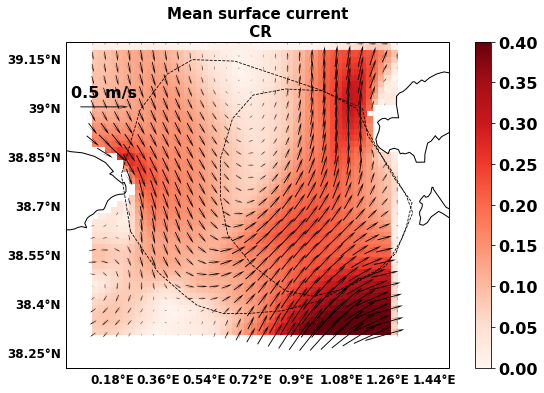

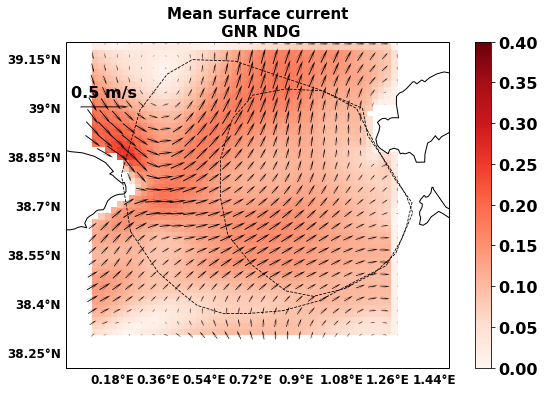

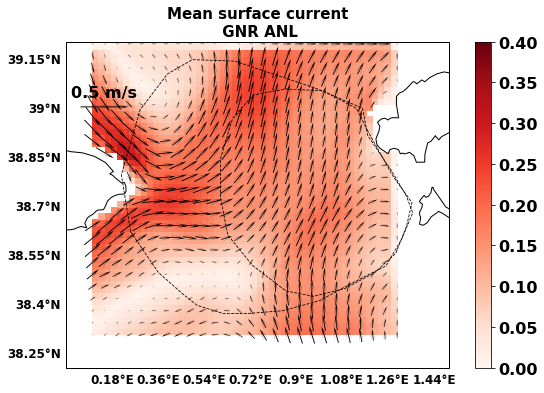

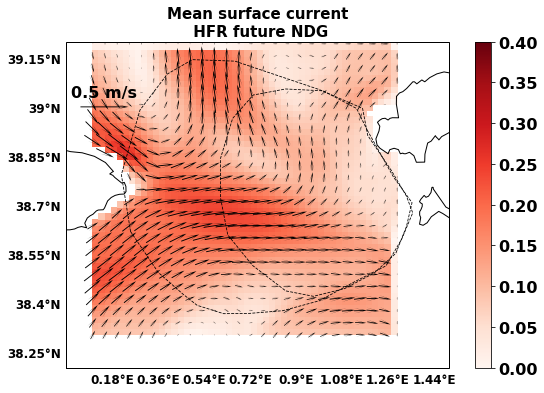

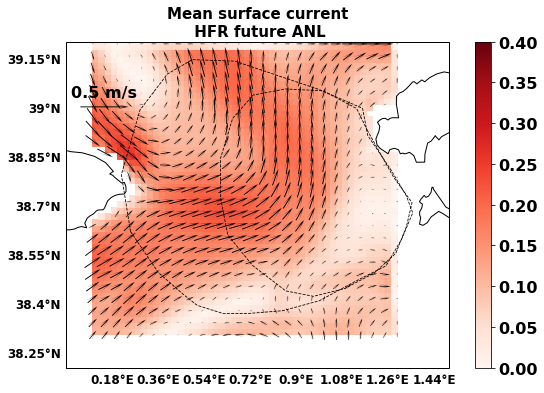

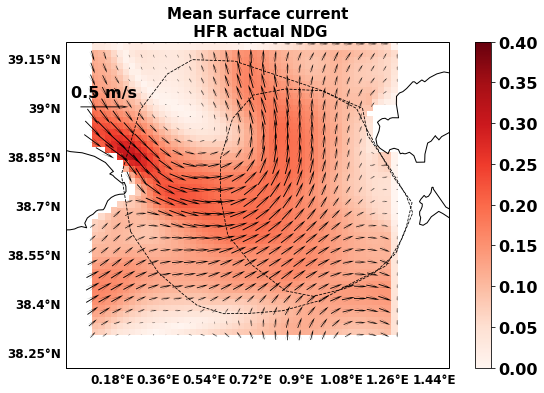

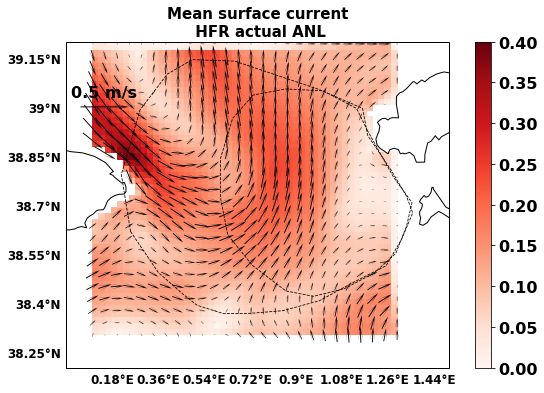

In [50]:
sset=2

lon_rho = ds_wmop['lon_rho'].where((ds_wmop.lon_rho>limits[0]) & (ds_wmop.lon_rho<limits[1]) & (ds_wmop.lat_rho>limits[2]) & (ds_wmop.lat_rho<limits[3]), drop=True)
lat_rho = ds_wmop['lat_rho'].where((ds_wmop.lon_rho>limits[0]) & (ds_wmop.lon_rho<limits[1]) & (ds_wmop.lat_rho>limits[2]) & (ds_wmop.lat_rho<limits[3]), drop=True)
lon = lon_rho.values[::sset, ::sset]
lat = lat_rho.values[::sset, ::sset]

# Experiment Names
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['CR', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']


for i, exp in enumerate(exp_names):

    u_mean = tools.u2rho_2d(np.mean(u[exp], axis=0))
    uq = u_mean[::sset, ::sset]
    v_mean = tools.v2rho_2d(np.mean(v[exp], axis=0))
    vq = v_mean[::sset, ::sset]


    fig = plt.figure(figsize=(9,6))

    ax, gl = tools.make_map(continents=False, limits=[0, 1.5, 38.2, 39.2], subplot_dim=111)
    plt.pcolormesh(lon_rho, lat_rho, np.sqrt(u_mean**2 + v_mean**2), transform=gl.crs, cmap='Reds', vmin=0, vmax=0.4)
    cb = plt.colorbar()
    
    plt.plot(lonc['actual'], latc['actual'], 'k--', transform=gl.crs, linewidth=0.8)
    plt.plot(lonc['future'], latc['future'], 'k--', transform=gl.crs, linewidth=0.8)
    
    q = ax.quiver(lon, lat, uq, vq, transform=gl.crs, scale=4, animated=True, headlength=15, headwidth=6, pivot='middle')
    ax.quiverkey(q, 0.1, 0.8,0.5,'0.5 m/s')
    plt.title('Mean surface current\n {0}'.format(labels[i]), fontsize=15, fontweight='bold')

    plt.show()
    
    fig.savefig('/home/jhernandez/Escritorio/OSSE_v2/mean_surface_current_ibiza_channel_{0}_OSSE.png'.format(exp), dpi=250)

## Plot the mean observed Surface current from the NR

NameError: name 'lonc' is not defined

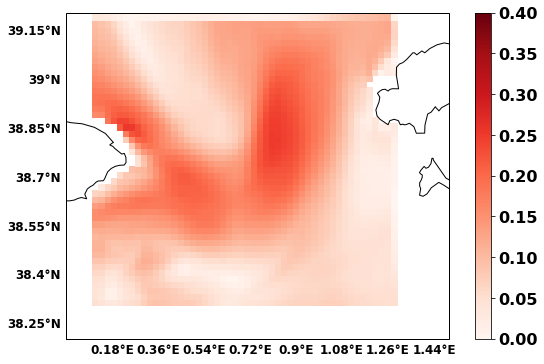

In [48]:
sset=2

lon_rho = ds_wmop['lon_rho'].where((ds_wmop.lon_rho>limits[0]) & (ds_wmop.lon_rho<limits[1]) & (ds_wmop.lat_rho>limits[2]) & (ds_wmop.lat_rho<limits[3]), drop=True)
lat_rho = ds_wmop['lat_rho'].where((ds_wmop.lon_rho>limits[0]) & (ds_wmop.lon_rho<limits[1]) & (ds_wmop.lat_rho>limits[2]) & (ds_wmop.lat_rho<limits[3]), drop=True)
lon = lon_rho.values[::sset, ::sset]
lat = lat_rho.values[::sset, ::sset]


u_mean = tools.u2rho_2d(np.mean(u_obs, axis=0))
uq = u_mean[::sset, ::sset]
v_mean = tools.v2rho_2d(np.mean(v_obs, axis=0))
vq = v_mean[::sset, ::sset]


fig = plt.figure(figsize=(9,6))

ax, gl = tools.make_map(continents=False, limits=[0, 1.5, 38.2, 39.2], subplot_dim=111)
plt.pcolormesh(lon_rho, lat_rho, np.sqrt(u_mean**2 + v_mean**2), transform=gl.crs, cmap='Reds', vmin=0, vmax=0.4)
cb = plt.colorbar()

plt.plot(lonc['actual'], latc['actual'], 'k--', transform=gl.crs, linewidth=0.8)
plt.plot(lonc['future'], latc['future'], 'k--', transform=gl.crs, linewidth=0.8)

q = ax.quiver(lon, lat, uq, vq, transform=gl.crs, scale=4, animated=True, headlength=15, headwidth=6, pivot='middle')
ax.quiverkey(q, 0.1, 0.8,0.5,'0.5 m/s')
plt.title('Mean surface current\n NR', fontsize=15, fontweight='bold')

fig.savefig('/home/jhernandez/Escritorio/OSSE_v2/mean_surface_current_ibiza_channel_NR_OSSE.png', dpi=250)

plt.show()